In [5]:
%matplotlib inline
from collections import defaultdict, Counter
import glob
import os
import json

from IPython.core.display import HTML, Image
from matplotlib_venn import venn3
import pandas as pd
import pybedtools
import pysam
import gspread
from gscripts.general import parsers
from gscripts.general import dataviz
%load_ext autoreload
import numpy as np
%autoreload 2
reload(parsers)
reload(pybedtools)
import seaborn as sns
import matplotlib
from oauth2client.client import SignedJwtAssertionCredentials
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

img_dir = "/home/gpratt/Dropbox/encode_integration/qc_work/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from matplotlib import rc
rc('text', usetex=False)
matplotlib.rcParams['svg.fonttype'] = 'none'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

# Load all master QC values

In [7]:
final_qc_frame = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/encode_master_qc.csv")
final_qc_frame = final_qc_frame.fillna("")
final_qc_frame = final_qc_frame.set_index(keys=["rbp", "encode_id", "rep", "cell_type", "full_name", "barcode"])

encode_qc = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/unannoated_encode_master_qc.csv", index_col=0)


In [8]:
filtered_final_qc_frame = final_qc_frame[[ "Input Reads", "Reads Written", "repetitive_count", "Reads Passing Quality Filter",
                                          "Uniquely Mapped Reads", "Uniquely mapped reads %", 'Number of reads mapped to too many loci',
                                          '% of reads unmapped: too short', '% of reads mapped to too many loci', "Usable Reads",
                                          "Fraction Collapsed", "Fraction Usable", "Num Peaks",]]

filtered_final_qc_frame.to_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/master_qc_filtered_v13.csv")

In [9]:
final_qc_frame.xs("204", level="encode_id").xs("01", level="rep")

Hiseq_file_name ENCODE_ID  \
rbp    cell_type full_name barcode                                       
RBFOX2 HepG2     204_01    A01      RBFOX2_204_CLIP-22583561    204_01   
                           B06      RBFOX2_204_CLIP-22583561    204_01   

                                       RBP inline_1 inline_2 index_1  index_2  \
rbp    cell_type full_name barcode                                              
RBFOX2 HepG2     204_01    A01      RBFOX2      A01      B06     501      702   
                           B06      RBFOX2      A01      B06     501      702   

                                   Lane  \
rbp    cell_type full_name barcode        
RBFOX2 HepG2     204_01    A01       S1   
                           B06       S1   

                                                                        file_location  \
rbp    cell_type full_name barcode                                                      
RBFOX2 HepG2     204_01    A01      /projects/ps-yeolab/seqdata/20150224_encode_CL...   
                           B06      /projects/ps-yeolab/seqdata/20150224_encode_CL...   

                                   unmerged_location   ...    \
rbp    cell_type full_name barcode                     ...     
RBFOX2 HepG2     204_01    A01                         ...     
                           B06                         ...     

                                   Uniquely mapped reads % rmRep  \
rbp    cell_type full_name barcode                                 
RBFOX2 HepG2     204_01    A01                            12.37%   
                           B06                            12.91%   

                                   Uniquely mapped reads number rmRep  \
rbp    cell_type full_name barcode                                      
RBFOX2 HepG2     204_01    A01                                 586883   
                           B06                                 643069   

                                   Percent Usable / Input  \
rbp    cell_type full_name barcode                          
RBFOX2 HepG2     204_01    A01                   0.784349   
                           B06                   0.797865   

                                   Percent Usable / Mapped  Passed QC  \
rbp    cell_type full_name barcode                                      
RBFOX2 HepG2     204_01    A01                    0.427346       True   
                           B06                    0.424493       True   

                                   Fraction Collapsed Fraction Usable  \
rbp    cell_type full_name barcode                                      
RBFOX2 HepG2     204_01    A01               0.784349        0.427346   
                           B06               0.797865        0.424493   

                                   barcode.1 exp_id rep_num  
rbp    cell_type full_name barcode                           
RBFOX2 HepG2     204_01    A01           A01    204      01  
                           B06           B06    204      01  

[2 rows x 139 columns]

In [10]:
print "\n".join(filtered_final_qc_frame.columns)

Input Reads
Reads Written
repetitive_count
Reads Passing Quality Filter
Uniquely Mapped Reads
Uniquely mapped reads %
Number of reads mapped to too many loci
% of reads unmapped: too short
% of reads mapped to too many loci
Usable Reads
Fraction Collapsed
Fraction Usable
Num Peaks


In [11]:
filtered_final_qc_frame[filtered_final_qc_frame['Reads Passing Quality Filter'] == 0]

,,,,,,Input Reads,Reads Written,repetitive_count,Reads Passing Quality Filter,Uniquely Mapped Reads,Uniquely mapped reads %,Number of reads mapped to too many loci,% of reads unmapped: too short,% of reads mapped to too many loci,Usable Reads,Fraction Collapsed,Fraction Usable,Num Peaks
rbp,encode_id,rep,cell_type,full_name,barcode,,,,,,,,,,,,,


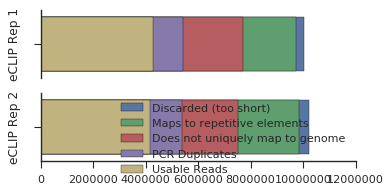

In [12]:
rbfox2_example = final_qc_frame.xs("204", level="encode_id").xs("01", level="rep")
rbfox2_example_02 = final_qc_frame.xs("204", level="encode_id").xs("02", level="rep")

c1, c2, c3, c4, c5 = sns.color_palette(palette="deep", n_colors=5)
sns.set_style("ticks")

num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "reads_removed.svg"), figsize=(5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(2,1,1)

    sns.barplot([rbfox2_example["Input Reads"].sum()], color=c1, ax=ax, label="Discarded (too short)")
    sns.barplot([rbfox2_example["Reads Written Round 2"].sum()], color=c2, ax=ax, label="Maps to repetitive elements")
    sns.barplot([rbfox2_example["Reads Passing Quality Filter"].sum()], color=c3, ax=ax, label="Does not uniquely map to genome")
    sns.barplot([rbfox2_example["Uniquely Mapped Reads"].sum()], color=c4, ax=ax, label="PCR Duplicates")
    sns.barplot([rbfox2_example["Usable Reads"].sum()], ax=ax, label="Usable Reads", color=c5)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    sns.despine(ax=ax, bottom=True)
    ax.set_xticks([])
    ax.set_ylabel("eCLIP Rep 1")
    
    ax = fig.add_subplot(2,1,2)

    sns.barplot([rbfox2_example_02["Input Reads"].sum()], color=c1, ax=ax, label="Discarded (too short)")
    sns.barplot([rbfox2_example_02["Reads Written Round 2"].sum()], color=c2, ax=ax, label="Maps to repetitive elements")
    sns.barplot([rbfox2_example_02["Reads Passing Quality Filter"].sum()], color=c3, ax=ax, label="Does not uniquely map to genome")
    sns.barplot([rbfox2_example_02["Uniquely Mapped Reads"].sum()], color=c4, ax=ax, label="PCR Duplicates")
    sns.barplot([rbfox2_example_02["Usable Reads"].sum()], ax=ax, label="Usable Reads", color=c5)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    sns.despine(ax=ax)
    ax.set_ylabel("eCLIP Rep 2")

    ax.legend()

In [9]:
grouped_final_qc_frame = filtered_final_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name']).sum()
grouped_final_qc_frame["Fraction Collapsed"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_qc_frame["Fraction Usable"] = grouped_final_qc_frame['Usable Reads'] / grouped_final_qc_frame['Input Reads'].astype(float)
# grouped_final_qc_frame = grouped_final_qc_frame.drop("Num Peaks", axis=1)
grouped_final_qc_frame = grouped_final_qc_frame.dropna()

In [10]:
encode_only_qc = grouped_final_qc_frame[[item[0].isdigit() and item[-1].isdigit() for item in grouped_final_qc_frame.index.get_level_values(level="encode_id")]]

merged_clip_manifest = encode_qc[["merged" in index for index in encode_qc.index]]
merged_clip_manifest.index = merged_clip_manifest.index.map(lambda x: "_".join(x.split("_")[:-1]))
merged_clip_manifest = merged_clip_manifest[['spot', 'Num Peaks']]

encode_only_qc['full_name'] = encode_only_qc.index.get_level_values(level="full_name")
encode_only_qc = pd.merge(encode_only_qc, merged_clip_manifest, left_on="full_name", right_index=True, how="outer")

encode_only_qc.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/encode_master_qc_v13.csv")

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
encode_only_qc.head()

Input Reads  repetitive_count  \
rbp  encode_id rep   cell_type full_name                                  
AARS 624       01              624_01      21583465.0         8351867.0   
               02              624_02      30790266.0        13953305.0   
               INPUT           624_INPUT   31578811.0        17226225.0   
     636       01              636_01       4687366.0         2979744.0   
               02              636_02       5863818.0         3579854.0   

                                          Reads Passing Quality Filter  \
rbp  encode_id rep   cell_type full_name                                 
AARS 624       01              624_01                       11595442.0   
               02              624_02                       15214764.0   
               INPUT           624_INPUT                    14347321.0   
     636       01              636_01                        1517186.0   
               02              636_02                        2046851.0   

                                          Uniquely Mapped Reads  \
rbp  encode_id rep   cell_type full_name                          
AARS 624       01              624_01                 7462151.0   
               02              624_02                 9926972.0   
               INPUT           624_INPUT             11076768.0   
     636       01              636_01                  751831.0   
               02              636_02                 1305420.0   

                                          Number of reads mapped to too many loci  \
rbp  encode_id rep   cell_type full_name                                            
AARS 624       01              624_01                                    742203.0   
               02              624_02                                   1171363.0   
               INPUT           624_INPUT                                 868614.0   
     636       01              636_01                                     87292.0   
               02              636_02                                    156696.0   

                                          Usable Reads  Fraction Collapsed  \
rbp  encode_id rep   cell_type full_name                                     
AARS 624       01              624_01        1070845.0            0.143504   
               02              624_02        1240709.0            0.124984   
               INPUT           624_INPUT    10296357.0            0.929545   
     636       01              636_01         136424.0            0.181456   
               02              636_02         134837.0            0.103290   

                                          Fraction Usable  full_name  \
rbp  encode_id rep   cell_type full_name                               
AARS 624       01              624_01            0.049614     624_01   
               02              624_02            0.040295     624_02   
               INPUT           624_INPUT         0.326053  624_INPUT   
     636       01              636_01            0.029105     636_01   
               02              636_02            0.022995     636_02   

                                              spot  Num Peaks  
rbp  encode_id rep   cell_type full_name                       
AARS 624       01              624_01     0.164061    71017.0  
               02              624_02     0.201463    78123.0  
               INPUT           624_INPUT       NaN        NaN  
     636       01              636_01     0.152912     7090.0  
               02              636_02     0.530785    18886.0

In [12]:
def add_metrics(metrics_files, encode_only_qc, name):
    filtered_frip_v12 = pd.DataFrame(pd.Series({os.path.basename(metrics_file).split(".")[0]: parsers.parse_peak_metrics(metrics_file)['spot'] for metrics_file in metrics_files}, 
                                       name=name))

    encode_only_qc = pd.merge(encode_only_qc, filtered_frip_v12, left_on="full_name", right_index=True, how="outer")
    return encode_only_qc

def add_metrics_v2(metrics_files, encode_only_qc, name):
    filtered_frip_v12 = pd.concat({"_".join(os.path.basename(metrics_file).split("_")[:2]) : pd.read_table(metrics_file) for metrics_file in metrics_files})
    filtered_frip_v12.index = filtered_frip_v12.index.get_level_values(level=0)
    filtered_frip_v12.columns = filtered_frip_v12.columns.map(lambda x: name + x)
    
    encode_only_qc = pd.merge(encode_only_qc, filtered_frip_v12, left_on="full_name", right_index=True, how="outer")
    return encode_only_qc

def add_metrics_v3(metrics_files, encode_only_qc, name):
    filtered_frip_v12 = pd.concat({os.path.basename(metrics_file).split(".")[0] : pd.read_table(metrics_file) for metrics_file in metrics_files})
    filtered_frip_v12.index = filtered_frip_v12.index.get_level_values(level=0)
    filtered_frip_v12.columns = filtered_frip_v12.columns.map(lambda x: name + x)
    
    encode_only_qc = pd.merge(encode_only_qc, filtered_frip_v12, left_on="full_name", right_index=True, how="outer")
    return encode_only_qc

In [13]:
encode_only_qc = add_metrics(glob.glob("/home/gpratt/projects/encode/analysis/peak_reanalysis_v12/*.metrics"), encode_only_qc, "filtered_spot_v12")
encode_only_qc = add_metrics(glob.glob("/home/gpratt/projects/encode/analysis/peak_reanalysis_v13/*.metrics"), encode_only_qc, "filtered_spot_v13")
encode_only_qc = add_metrics(glob.glob("/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/*l2fc_5_pval_3.clipper.metrics"), encode_only_qc, "lfc2_5_pval_3")
encode_only_qc = add_metrics(glob.glob("/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/*l2fc_0_pval_1.clipper.metrics"), encode_only_qc, "l2fc_0_pval_1")
encode_only_qc = add_metrics(glob.glob("/home/gpratt/projects/encode/analysis/peak_reanalysis_v14/*l2fc_2_pval_1.3.clipper.metrics"), encode_only_qc, "l2fc_2_pval_1.3")

KeyboardInterrupt: 

In [14]:
encode_only_qc = add_metrics_v2(glob.glob("/home/gpratt/projects/encode/analysis/genic_binding/*.in_genes.metrics"), encode_only_qc, "in_genes_")
encode_only_qc = add_metrics_v3(glob.glob("/home/gpratt/projects/encode/analysis/entropy_test_v1/*l2fc_5_pval_3.clipper.metrics"), encode_only_qc, "lfc2_5_pval_3_")
encode_only_qc = add_metrics_v3(glob.glob("/home/gpratt/projects/encode/analysis/entropy_test_v1/*l2fc_0_pval_1.clipper.metrics"), encode_only_qc, "l2fc_0_pval_1_")
encode_only_qc = add_metrics_v3(glob.glob("/home/gpratt/projects/encode/analysis/entropy_test_v1/*l2fc_2_pval_1.3.clipper.metrics"), encode_only_qc, "l2fc_2_pval_1.3_")

In [15]:
encode_only_qc = add_metrics_v2(glob.glob("/home/gpratt/projects/encode/analysis/exon_binding/*.metrics"), encode_only_qc, "in_exons_")

In [16]:
encode_only_qc['entropy'] = encode_only_qc['lfc2_5_pval_3'] * np.log2(encode_only_qc['lfc2_5_pval_3'] / encode_only_qc['lfc2_5_pval_3_FRiP'])

In [17]:
#sns.distplot(encode_only_qc['entropy'].dropna())

In [18]:
only_clip = pd.concat([encode_only_qc.xs("01", level="rep"), encode_only_qc.xs("02", level="rep")])
only_clip['uID'] = only_clip.index.get_level_values(level="encode_id")

In [14]:
grouped_final_qc_frame.to_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/master_qc_v13.csv")

HTML(grouped_final_qc_frame.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads Written" : parsers.commas,
                                     "repetitive_count": parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas,
                                     "Num Peaks": parsers.commas
                                     } ))

In [21]:
background = sns.color_palette("Blues")[1]
foreground = sns.color_palette("Blues")[-1]

ValueError: array must not contain infs or NaNs

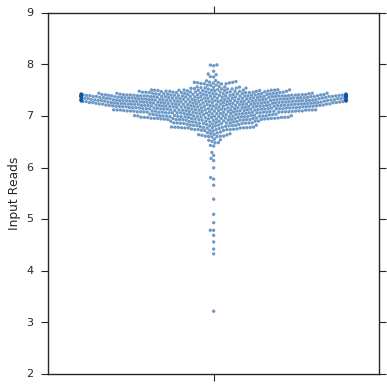

In [22]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "number_of_input_reads.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.swarmplot(y=np.log10(only_clip['Input Reads']), color=foreground, alpha=.6, size=3, ax=ax)
    sns.violinplot(y=np.log10(only_clip['Input Reads']), color=background, linewidth=0, ax=ax)
    ax.set_ylabel("Number of Input Reads", fontsize=26)
    ax.set_ylim(3,8)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_yticklabels([pow(10, x) for x in range(3, 9)])
    ax.set_xlabel("ENCODE eCLIP", fontsize=26)
    [tick.set_fontsize(22) for tick in ax.get_yticklabels()]

    sns.despine()

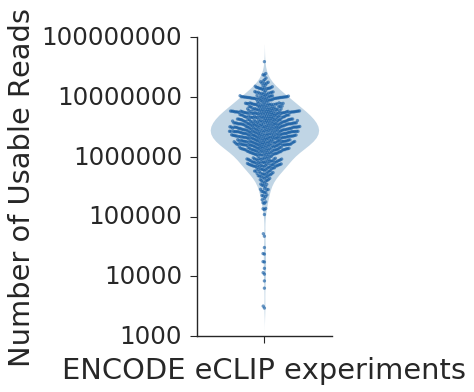

In [23]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "number_of_usable_reads.svg"), figsize=(5.0 * num_cols,5.0*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    sns.swarmplot(y=np.log10(only_clip['Usable Reads']), color=foreground, alpha=.6, size=3, ax=ax)
    sns.violinplot(y=np.log10(only_clip['Usable Reads']), color=background, linewidth=0, ax=ax)
    ax.set_ylabel("Number of Usable Reads", fontsize=26)
    ax.set_ylim(3,8)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_yticklabels([pow(10, x) for x in range(3, 9)])
    [tick.set_fontsize(22) for tick in ax.get_yticklabels()]

    ax.set_xlabel("ENCODE eCLIP experiments", fontsize=26)
    sns.despine()

In [24]:
# num_rows = 1 
# num_cols = 1 
# with dataviz.Figure(os.path.join(img_dir, "fraction_of_reads_in_genes.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
#     ax = fig.add_subplot(1,1,1)
#     sns.violinplot(y=encode_only_qc.FRiP, ax=ax)
#     ax.set_ylabel("Fraction of Reads in Genes")
#     ax.set_ylim(0,)
#     ax.set_xlabel("ENCODE eCLIP")
#     sns.despine()

This was a wasate of time, its the fraction of reads within genic regions.  Spoiler alert: all datasets have a FRIP of ~80 basically a good RNA-seq library.  We are going find bad datasets this way. The only "bad" datasets are stuff that bind tRNAs, and an unannotated mitochondiral transcript

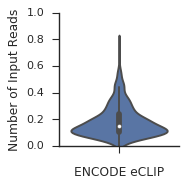

In [25]:
num_rows = 1 
num_cols = 1 
with dataviz.Figure(os.path.join(img_dir, "number_of_input_reads.svg"), figsize=(2.5 * num_cols,2.5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    #sns.swarmplot(y=only_clip['Input Reads'], color='.1', alpha=.6, ax=ax)
    sns.violinplot(y=only_clip.spot, ax=ax)
    ax.set_ylabel("Number of Input Reads")
    ax.set_ylim(0,)
    ax.set_xlabel("ENCODE eCLIP")
    sns.despine()

In [26]:
ids_good_to_go_old = """
204
205
211
215
216
218
220
222
223
224
226
230
236
240
241
242
243
244
245
246
247
249
256
258
260
262
267
278
280
281
283
290
291
203
271
206
209
227
228
237
272
275
279
282
289
291
292
297
298
301
302
312
315
316
321
325
326
331
332
240
338
339
340
341
342
344
345
350
352
353
354
358
366
367
368
384
387
388
393
405
508
497
495
494
477
465
464
452
415
417
484
439
440
441
444
445
447
450
466
478
311
480
481
492
506
383
376
414
425
437
460
461
470
483
507
509
514
516
530
537
539
540
543
544
546
552
553
556
558
560
566
603
235
390
491
501
503
522
529
531
548
550
567
570
577
582
584
589
592
595
596
614
617
624
625
626
628
641
533
538
545
551
629
631
285
493
571
572
575
610
632
649
650
652
654
655
658
668
676
677
678
679
682
684
693
695
696""".split("\n")

ids_good_to_go = [] # """285""".split("\n")

ids_good_to_go_4000 = """235
390
285""".split("\n")

ids_good_to_go_4000 = map(str, ids_good_to_go_4000)
ids_good_to_go = ids_good_to_go_old + ids_good_to_go
passed_qc = ids_good_to_go

In [27]:
HTML(only_clip[~only_clip.uID.isin(passed_qc)].sort_index().to_html())

In [28]:
only_qc_clip = only_clip[only_clip.uID.astype(int) <= 697]

In [29]:
passed_plot = []
passed_plot.append(len(set(only_qc_clip[only_qc_clip.uID.isin(passed_qc)].uID)))
passed_plot.append(len(set(only_qc_clip[~only_qc_clip.uID.isin(passed_qc)].uID)))

In [30]:
dataviz.Figure??

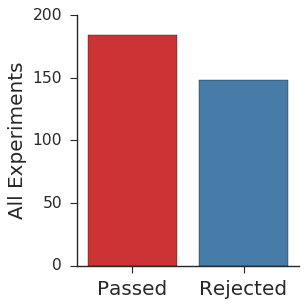

In [31]:
with dataviz.Figure(os.path.join(img_dir, "grad_slam_passed_plot.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)  
    # Generate some sequential data
    x = np.array(["Passed", "Rejected"])
    sns.barplot(x, passed_plot, palette="Set1", ax=ax)
    ax.set_ylabel("All Experiments", fontsize=18)
    [tick.set_fontsize(18) for tick in ax.get_xticklabels()]
    [tick.set_fontsize(14) for tick in ax.get_yticklabels()]

    sns.despine(ax=ax)

In [32]:
def confusion_numbers(threshold, col):
    passed_frip = only_clip[only_clip[col]  >= threshold]
    failed_frip = only_clip[only_clip[col]  < threshold]
    
    tp = len(passed_frip[passed_frip.uID.isin(passed_qc)]) * 1.0
    fp = len(passed_frip[~passed_frip.uID.isin(passed_qc)]) * 1.0

    fn = len(failed_frip[failed_frip.uID.isin(passed_qc)]) * 1.0
    tn = len(failed_frip[~failed_frip.uID.isin(passed_qc)]) * 1.0
    
    return tp, fp, fn, tn

In [33]:
threshold = .005

In [34]:
def get_best_f_score(column_name):
    true_positive_array = []
    false_positive_array = []
    threshold_array = []

    max_true_positive_rate = 0

    for threshold in np.arange(0,1, .001):

        tp, fp, fn, tn = confusion_numbers(threshold, column_name)
        try:
            true_positive_rate = tp / (tp + fn)
            false_positive_rate = fp / (fp + tn)

            precision = tp / (tp + fp)
            recall = tp / (tp + fn)

            f_score = 2 * ((precision * recall) / (precision + recall))
        except ZeroDivisionError as e:
            print e
            break
        #lr = true_positive_rate / false_positive_rate
        if max_true_positive_rate < f_score:
            max_true_positive_rate = f_score
            best_threshold = threshold 

        true_positive_array.append(true_positive_rate)
        false_positive_array.append(false_positive_rate)
        threshold_array.append(threshold)

    print max_true_positive_rate
    print best_threshold

In [35]:
get_best_f_score("lfc2_5_pval_3")

float division by zero
0


UnboundLocalError: local variable 'best_threshold' referenced before assignment

In [ ]:
confusion_numbers(.01, "lfc2_5_pval_3")

In [ ]:
get_best_f_score("l2fc_0_pval_1")

In [ ]:
confusion_numbers(.039, "l2fc_0_pval_1")

In [ ]:
get_best_f_score("l2fc_2_pval_1.3")

In [ ]:
confusion_numbers(0.021, "l2fc_2_pval_1.3")

In [ ]:
get_best_f_score("filtered_spot_v12")

In [ ]:
get_best_f_score("filtered_spot_v13")

In [ ]:
get_best_f_score("entropy")

In [ ]:
confusion_numbers(0.02, "entropy")

In [ ]:
only_clip[(only_clip.entropy < .02) & only_clip.uID.isin(passed_qc)]

In [36]:
true_positive_array = []
false_positive_array = []
threshold_array = []

max_true_positive_rate = 0

for threshold in np.arange(0,1, .001):

    tp, fp, fn, tn = confusion_numbers(threshold, "filtered_spot_v13")
    try:
        true_positive_rate = tp / (tp + fn)
        false_positive_rate = fp / (fp + tn)
    
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
        f_score = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError as e:
        print e
        break
    #lr = true_positive_rate / false_positive_rate
    if max_true_positive_rate < f_score:
        max_true_positive_rate = f_score
        best_threshold = threshold 
        
    true_positive_array.append(true_positive_rate)
    false_positive_array.append(false_positive_rate)
    threshold_array.append(threshold)

print max_true_positive_rate
print best_threshold

float division by zero
0.786802030457
0.012


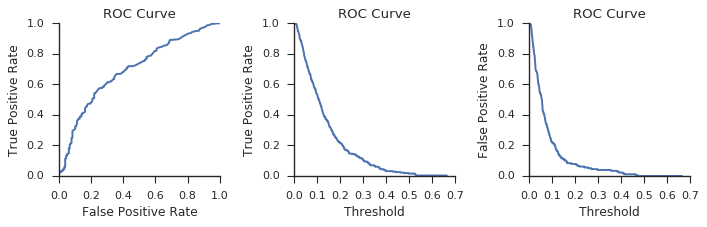

In [37]:
num_rows = 1
num_cols = 3
with dataviz.Figure(os.path.join(img_dir, "reproducibility_test_passed_qc_frip.svg"), figsize=(3 * num_cols, 3 * num_rows)) as fig:
    ax = fig.add_subplot(1,3,1)
    ax.plot(false_positive_array, true_positive_array)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")

    ax = fig.add_subplot(1,3,2)
    ax.plot(threshold_array, true_positive_array)
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("Threshold")
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(threshold_array, false_positive_array)
    ax.set_ylabel("False Positive Rate")
    ax.set_xlabel("Threshold")
    sns.despine(ax=ax)
    ax.set_title("ROC Curve")

In [38]:
#HTML(pd.DataFrame(only_clip.filtered_spot.sort_values(ascending=False)).to_html())

In [39]:
only_clip["passed_qc"] = only_clip.uID.isin(passed_qc)
only_clip['foo'] = "ENCODE eCLIP"
only_clip_filtered = only_clip[only_clip.lfc2_5_pval_3 < .1]

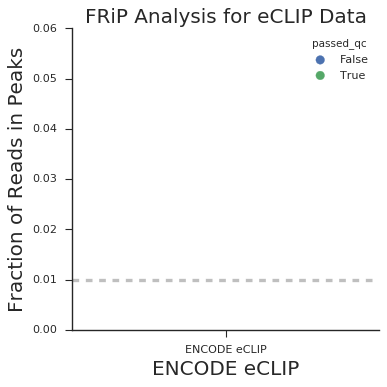

In [40]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "frip_distribution.svg"), figsize=(5 * num_cols, 5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    #sns.swarmplot(y=only_clip['Input Reads'], color='.1', alpha=.6, ax=ax)
    #sns.swarmplot(y=only_clip.lfc2_5_pval_3, hue=only_clip.passed_qc, data=only_clip, ax=ax)
    sns.swarmplot(x="foo", y="lfc2_5_pval_3", hue="passed_qc", data=only_clip, ax=ax)
    
    ax.set_ylabel("Fraction of Reads in Peaks", fontsize=18)
    ax.set_ylim(0,)
    #ax.set_xlim(0,.3)
    ax.set_xlabel("ENCODE eCLIP", fontsize=18)
    ax.set_title("FRiP Analysis for eCLIP Data", fontsize=18)
    ax.axhline(.01, linestyle="--", linewidth=3, color='.75')
    sns.despine()

ValueError: min() arg is an empty sequence

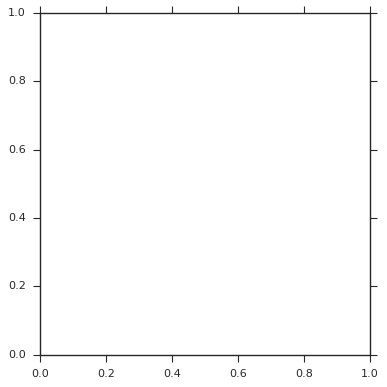

In [41]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "frip_distribution_filtered.svg"), figsize=(5 * num_cols, 5*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    #sns.swarmplot(y=only_clip['Input Reads'], color='.1', alpha=.6, ax=ax)
    #sns.swarmplot(y=only_clip.lfc2_5_pval_3, hue=only_clip.passed_qc, data=only_clip, ax=ax)
    sns.swarmplot(x="foo", y="lfc2_5_pval_3", hue="passed_qc", data=only_clip_filtered, ax=ax)
    
    ax.set_ylim(0,)
    #ax.set_xlim(0,.3)
    ax.set_xlabel("ENCODE eCLIP", fontsize=18)
    ax.set_title("FRiP Analysis for eCLIP Data", fontsize=18)
    ax.axhline(.01, linestyle="--", linewidth=3, color='.75')
    sns.despine()

# GRCh38 QC

In [ ]:
encode_GRCh38_qc = parsers.clipseq_metrics("/projects/ps-yeolab3/encode/analysis/encode_GRCh38_v1/", iclip=True)
encode_GRCh38_qc["Fraction Collapsed"] = encode_GRCh38_qc['Usable Reads'] / encode_GRCh38_qc['Uniquely Mapped Reads'].astype(float)
encode_GRCh38_qc["Fraction Usable"] = encode_GRCh38_qc['Usable Reads'] / encode_GRCh38_qc['Input Reads'].astype(float)
encode_GRCh38_qc['barcode'] = encode_GRCh38_qc.index.map(lambda x: x.split(".")[1].split("_")[0])

unmerged_clip_manifest = encode_GRCh38_qc[["merged" not in index for index in encode_GRCh38_qc.index]]

tmp = pd.merge(manifest_df, unmerged_clip_manifest, left_on="qc_name", right_index=True)

final_GRCh38_qc_frame = pd.merge(manifest, tmp, left_on='qc_id', right_on='encode_id')

final_GRCh38_qc_frame['exp_id'] = final_GRCh38_qc_frame.ENCODE_ID.apply(lambda x:x.split("_")[0])
final_GRCh38_qc_frame['rep_num'] = final_GRCh38_qc_frame.ENCODE_ID.apply(get_rep_num)
final_GRCh38_qc_frame['Input Reads'] = final_GRCh38_qc_frame['Input Reads'].fillna(0)

new_index = []
for index, row in final_GRCh38_qc_frame.iterrows():
    new_index.append([row.RBP, row.exp_id, row.rep_num, row.cell_type, row.ENCODE_ID, row.barcode])
    
final_GRCh38_qc_frame.index = pd.MultiIndex.from_tuples(new_index, names=['rbp', 'encode_id', 'rep', 'cell_type', "full_name", 'barcode'])
final_GRCh38_qc_frame = final_GRCh38_qc_frame.sort_index()

In [ ]:
final_GRCh38_qc_frame = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/encode_GRCh38_qc.csv")
final_GRCh38_qc_frame = final_GRCh38_qc_frame.fillna("")
final_GRCh38_qc_frame = final_GRCh38_qc_frame.set_index(keys=["rbp", "encode_id", "rep", "cell_type", "full_name", "barcode"])
encode_GRCh38_qc = pd.read_csv("/home/gpratt/Dropbox/EricGabe_ENCODE/unannoated_encode_GRCh38_qc.csv", index_col=0)

In [ ]:
filtered_final_GRCh38_qc_frame = final_GRCh38_qc_frame[["Hiseq_file_name", "ENCODE_ID", "RBP", "Input Reads",
                                #'Trimmed bases',
                            "Reads Written",
                            "repetitive_count",
                            "Uniquely Mapped Reads",
                            "Uniquely mapped reads %",
                            "Usable Reads",
                            "Fraction Collapsed",
                            "Fraction Usable",
                            #"spot",
                            "Num Peaks",
                            #"Passed QC"
                            ]]

In [ ]:
grouped_final_GRCh38_qc_frame = filtered_final_GRCh38_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name']).sum()
grouped_final_GRCh38_qc_frame["Fraction Collapsed"] = grouped_final_GRCh38_qc_frame['Usable Reads'] / grouped_final_GRCh38_qc_frame['Uniquely Mapped Reads'].astype(float)
grouped_final_GRCh38_qc_frame["Fraction Usable"] = grouped_final_GRCh38_qc_frame['Usable Reads'] / grouped_final_GRCh38_qc_frame['Input Reads'].astype(float)
grouped_final_GRCh38_qc_frame = grouped_final_GRCh38_qc_frame.drop("Num Peaks", axis=1)
grouped_final_GRCh38_qc_frame = grouped_final_GRCh38_qc_frame.dropna()

In [ ]:
grouped_final_GRCh38_qc_frame.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/master_qc_GRCh38_v1.csv")

HTML(grouped_final_GRCh38_qc_frame.to_html(formatters={"Input Reads" : parsers.commas,
                                     "Reads Written" : parsers.commas,
                                     "repetitive_count": parsers.commas,
                                     "Reads after Quality Filtering" : parsers.commas,
                                     "Uniquely Mapped Reads" : parsers.commas,
                                     "Usable Reads" : parsers.commas,
                                     "Num Peaks": parsers.commas
                                     } ))

In [ ]:
merged_qc_frame = pd.merge(final_GRCh38_qc_frame, final_qc_frame, left_index=True, right_index=True, suffixes=("_grch38", "_hg19")).dropna()
merged_qc_frame.to_csv("/home/gpratt/Dropbox/encode_integration/for_eric/master_qc_GRCh38_hg19_v1.csv")

In [ ]:
len(final_qc_frame)

In [ ]:
len(final_GRCh38_qc_frame)

In [ ]:
foo =merged_qc_frame.groupby(level=['rbp', 'encode_id', 'rep', 'cell_type', 'full_name', 'barcode']).count()

In [ ]:
merged_qc_frame.ix[foo.ENCODE_ID_grch38 > 1]

In [ ]:
numbers = ["Input Reads", "Reads Written", "repetitive_count", "Reads Passing Quality Filter",
                                          "Uniquely Mapped Reads", "Usable Reads",
                                          "Fraction Collapsed", "Fraction Usable", "Num Peaks"]

In [ ]:
num_rows = (len(numbers) / 2) + 1
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "numeric_distributions.svg"), figsize=(5 * num_cols, 5*num_rows)) as fig:
    for x, item in enumerate(numbers):
        
        ax = fig.add_subplot(num_rows,num_cols, x + 1)
        ax.scatter(merged_qc_frame['{}_hg19'.format(item)].values, 
                   merged_qc_frame['{}_grch38'.format(item)].values,
                  alpha=.7)
        sns.despine(ax=ax)
        ax.set_title(item)
        ax.set_ylabel("GRCh38")
        ax.set_xlabel("hg19")

In [ ]:
num_rows = 1
num_cols = 3
with dataviz.Figure(os.path.join(img_dir, "percent_distributions.svg"), figsize=(5 * num_cols, 5*num_rows)) as fig:
    
    
    ax = fig.add_subplot(num_rows,num_cols,1)
    
    ax.scatter(merged_qc_frame["Uniquely mapped reads %_hg19"].apply(lambda x: float(x[:-1])),
               merged_qc_frame["Uniquely mapped reads %_grch38"].apply(lambda x: float(x[:-1])),
               alpha=.7)
    sns.despine(ax=ax)
    ax.set_title("% Mapped")
    ax.set_ylabel("GRCh38")
    ax.set_xlabel("hg19")
    
    ax = fig.add_subplot(num_rows,num_cols,2)
    ax.scatter(merged_qc_frame[ '% of reads unmapped: too short_hg19'].apply(lambda x: float(x[:-1])),
               merged_qc_frame[ '% of reads unmapped: too short_grch38'].apply(lambda x: float(x[:-1])),
               alpha=.7)
    sns.despine(ax=ax)
    ax.set_title( '% of reads unmapped: too short')
    ax.set_ylabel("GRCh38")
    ax.set_xlabel("hg19")
    
    ax = fig.add_subplot(num_rows,num_cols,3)
    ax.scatter(merged_qc_frame['% of reads mapped to too many loci_hg19'].apply(lambda x: float(x[:-1])),
               merged_qc_frame['% of reads mapped to too many loci_grch38'].apply(lambda x: float(x[:-1])),
               alpha=.7)
    sns.despine(ax=ax)
    ax.set_title("% of reads mapped to too many loci")
    ax.set_ylabel("GRCh38")
    ax.set_xlabel("hg19")